In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

df = pd.read_csv('../Preprocessing/data_downsampling.csv', header=None)
df_y = pd.read_csv('../Preprocessing/data_output.csv', header=None)

X = df.values
y = df_y.iloc[:, 0].values

labels, y_encoded = np.unique(y, return_inverse=True)
y_encoded = to_categorical(y_encoded)  # 원-핫 인코딩

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 88, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 44, 64)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 44, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 42, 128)           24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 21, 128)          0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 21, 128)          

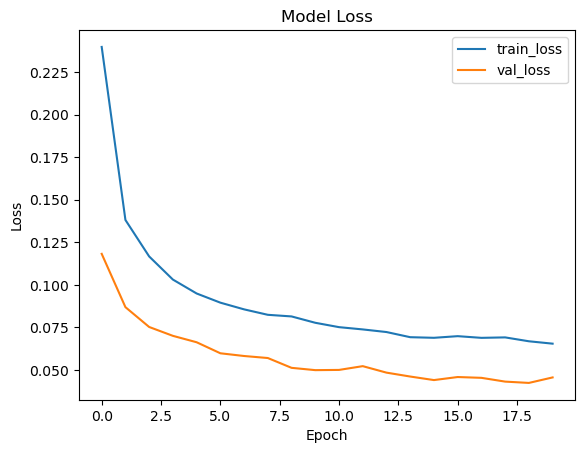

685/685 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           F       0.95      0.73      0.83       142
           N       0.99      1.00      0.99     18147
           Q       0.99      0.98      0.99      1612
           S       0.97      0.81      0.88       534
           V       0.97      0.96      0.97      1464

    accuracy                           0.99     21899
   macro avg       0.97      0.90      0.93     21899
weighted avg       0.99      0.99      0.99     21899



In [7]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=labels)
print(report)

In [14]:
incorrect_indices = np.where(y_pred_classes != y_test_classes)[0]

incorrect_predictions = pd.DataFrame({
    'Index': incorrect_indices,
    'True Label': y_test_classes[incorrect_indices],
    'Predicted Label': y_pred_classes[incorrect_indices]
})

# 틀린 예측 결과 출력
print(incorrect_predictions)

     Index  True Label  Predicted Label
0      101           3                1
1      201           4                1
2      205           0                1
3      280           3                1
4      342           4                1
..     ...         ...              ...
251  21514           3                1
252  21518           4                1
253  21644           3                1
254  21650           1                3
255  21700           3                1

[256 rows x 3 columns]
